In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [278]:
# %cd "/content/drive/MyDrive/CVProject"
%cd /content/drive/MyDrive/CV/Final Project

/content/drive/MyDrive/CV/Final Project


In [279]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)

#download CIFAR100 datasets
#download train_set and test_set separately
#also create dataloader for train and test respectively
#dataloader will give the inputs in a batch as specified by batch_size
train_set = datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

train_loader_100_classes = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

def comparator(x) :
  return x[1]

############################################################
#Below code is only required while training the extractor- UNCOMMENT TO TRAIN EXTRACTOR

# train_x = []
# train_y = []
# validate_x = []
# validate_y = []

# train_set_list = sorted(train_set, key=comparator)

# for x in train_set_list :
#   if x[1] < 80 :
#     train_x.append(x[0].numpy())
#     train_y.append(x[1])
#   else :
#     validate_x.append(x[0].numpy())
#     validate_y.append(x[1])


# train_x = torch.FloatTensor(train_x) # transform to torch tensor
# train_y = torch.FloatTensor(train_y)

# validate_x = torch.FloatTensor(validate_x) 
# validate_y = torch.FloatTensor(validate_y)


# train_dataset = TensorDataset(train_x,train_y) # create your datset
# #validate_dataset = TensorDataset(validate_x,validate_y)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# #validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size,
# #                                          shuffle=False, num_workers=2)



# #download resnet18 model
# resnet18 = models.resnet18(pretrained= True)

# #We will train on only the 80 classes
# resnet18.fc = nn.Linear(resnet18.fc.in_features, 80)

# #optimizer for training 
# feat_optimizer = optim.Adam(resnet18.parameters(), lr=0.001, betas=(0.5, 0.999))

# resnet18 = resnet18.to(device)
# criterion = nn.CrossEntropyLoss().to(device)

# #train resnet on CIFAR100, train loader contains only the 80 classes 
# num_epochs = 100
# resnet18.train()
# for epoch in range(num_epochs) :
#   totalloss = 0
#   for i,(batch_x, batch_y) in enumerate(train_loader) :
#     #train resnet, don't lock the weights
#     feat_optimizer.zero_grad()
#     resnet18.zero_grad()
#     batch_x = batch_x.to(device)
#     batch_y = batch_y.to(device).long()
#     predictions = resnet18(batch_x)
#     loss = criterion(predictions, batch_y)
#     totalloss += loss
#     loss.backward()
#     feat_optimizer.step()
#   print("Epoch : ", epoch, "Total Loss : ", totalloss)
    
# #save the model
# resnet18.eval()
# torch.save({
#       'F': resnet18.state_dict(),
#       }, 'FeatureExtractor.pth')

############################################################
#Below code is only required while training the extractor- UNCOMMENT TO TRAIN EXTRACTOR
###########################################################################


def getData(dataSet, k, n, start_class) :
  #dataSet = a map indexed with labels
  supportSet = []
  querySet = []
  sx = []
  sy = []
  qx = []
  qy = []
  for label in range(start_class, start_class + n) :
    ss = []
    for _ in range(k) :
      random_index = random.randint(0,len(dataSet[label]) - 1)
      supportSet.append(dataSet[label][random_index])
      ss.append(random_index)
    random_index2 = random.randint(0,len(dataSet[label]) - 1)
    while (random_index2 in ss) :
      random_index2 = random.randint(0,len(dataSet[label]) - 1)
    querySet.append(dataSet[label][random_index2])
  for item in supportSet :
    sx.append(item[0].numpy())
    sy.append(item[1])
  for item in querySet :
    qx.append(item[0].numpy())
    qy.append(item[1])
  sx = torch.FloatTensor(sx)
  sy = torch.LongTensor(sy)
  qx = torch.FloatTensor(qx)
  qy = torch.LongTensor(qy)

  supportSet = TensorDataset(sx,sy)
  querySet = TensorDataset(qx,qy)

  return supportSet, querySet

#s,q = getData(train_data, 10, True)

#download resnet18 model
resnet18 = models.resnet18(pretrained= True)

#CIFAR100 has 100 classes, so output layer of resnet18 is updated to 100
resnet18.fc = nn.Linear(resnet18.fc.in_features, 80)

#load model
path = "FeatureExtractor.pth"
checkpoint = torch.load(path)
resnet18.load_state_dict(checkpoint['F'])


#delete classification layer of the model
modules=list(resnet18.children())[:-1]
resnet18=nn.Sequential(*modules)
for p in resnet18.parameters():
    p.requires_grad = False

#generate features 
def generate_features(resnet18,data_loader):
  resnet18 = resnet18.to(device)
  resnet18.eval()
  features = []
  labels = []
  with torch.no_grad() :
    for i,(batch_x, batch_y) in enumerate(data_loader) :
      batch_x = batch_x.to(device)
      batch_y = batch_y.to(device)
      f = resnet18(batch_x).to('cpu')
      for x in f :
        features.append(x.numpy())
      for y in batch_y :
        labels.append(y)

  features = torch.FloatTensor(features)
  labels = torch.Tensor(labels)
  feature_dataset = TensorDataset(features,labels)
  return feature_dataset
#convert dataset to map, indexed by label
def convetDatasetToMap(feature_dataset) :
  feature_dataset_list = sorted(feature_dataset, key=comparator)
  feature_dataset_map = []
  prev = 0
  ls = []
  for x in feature_dataset_list :
    if x[1]!= prev :
      feature_dataset_map.append(ls)
      ls = []
    ls.append(x)
    prev = x[1]

  feature_dataset_map.append(ls)
  return feature_dataset_map
def getDataLoaders(feature_dataset_map,k,n,start_class) :
  s,q = getData(feature_dataset_map,k,n,start_class)
  dataloaderS = torch.utils.data.DataLoader(s,  batch_size=len(s), shuffle=False, num_workers=2)
  dataloaderQ = torch.utils.data.DataLoader(q,  batch_size=len(q), shuffle=False, num_workers=2)
  return dataloaderS, dataloaderQ
train_features_dataset = generate_features(resnet18,train_loader_100_classes)
train_features_map = convetDatasetToMap(train_features_dataset)

test_features_dataset = generate_features(resnet18,test_loader)
test_features_map = convetDatasetToMap(test_features_dataset)

Files already downloaded and verified
Files already downloaded and verified


In [280]:
#what i have to do 
# 1. write a function, that takes 2 datasets such that index i contains images of ith class
# 2. It will create support set from dataset1, queryset from dataset2

def getData2(dataSet1, dataSet2, k, n, start_class) :
  #dataSet = a map indexed with labels
  supportSet = []
  querySet = []
  sx = []
  sy = []
  qx = []
  qy = []
  for label in range(start_class, start_class + n) :
    ss = []
    for _ in range(k) :
      random_index = random.randint(0,len(dataSet1[label]) - 1)
      supportSet.append(dataSet1[label][random_index])
      ss.append(random_index)
    random_index2 = random.randint(0,len(dataSet2[label]) - 1)
    querySet.append(dataSet2[label][random_index2])
  
  #convert support set and query set to tensor dataset
  for item in supportSet :
    sx.append(item[0].numpy())
    sy.append(item[1])
  for item in querySet :
    qx.append(item[0].numpy())
    qy.append(item[1])
  sx = torch.FloatTensor(sx)
  sy = torch.LongTensor(sy)
  qx = torch.FloatTensor(qx)
  qy = torch.LongTensor(qy)

  supportSet = TensorDataset(sx,sy)
  querySet = TensorDataset(qx,qy)

  return supportSet, querySet

def getDataLoaders2(dataset1,dataset2,k,n,start_class) :
  s,q = getData2(dataset1,dataset2,k,n,start_class)
  dataloaderS = torch.utils.data.DataLoader(s,  batch_size=len(s), shuffle=False, num_workers=2)
  dataloaderQ = torch.utils.data.DataLoader(q,  batch_size=len(q), shuffle=False, num_workers=2)
  return dataloaderS, dataloaderQ

# s,q = getDataLoaders2(train_features_map, test_features_map,10,5,80)

In [281]:
class Generator(nn.Module):
    def __init__(self, feat_size):
        super(Generator, self).__init__()
        self.label_embeddings = nn.Embedding(80, feat_size)
        self.model = nn.Sequential(
            nn.Linear(feat_size * 2, 1024), # _ is size of z1 + s | opt.noise_size + opt.feat_size = feat_size * 2
            nn.LeakyReLU(0.2),
            nn.Linear(1024, feat_size), # _ is size of Feature vector
            nn.ReLU(0.2)    # Should we put Relu at end?
           
        )

    def forward(self, noise, labels, contexts):
        # noise and contexts shoul be 2d tensors | labels is 1d
        self.label_embeddings = nn.Embedding.from_pretrained(contexts, freeze=True, ) 
        input = torch.cat((noise.view(noise.size(0), -1), self.label_embeddings(labels)), -1)
        feats_gen = self.model(input)
        return feats_gen


In [282]:
class Discriminator(nn.Module):
    def __init__(self, feat_size):
       
        super(Discriminator, self).__init__()
        self.label_embeddings = nn.Embedding(80, feat_size)
        self.model = nn.Sequential(
            nn.Linear(feat_size * 2, 1024), # _ is (s' + s) = 2s
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            # nn.sigmoid(),  # WGAN
        )

    def forward(self, feat, labels, contexts):
      self.label_embeddings = nn.Embedding.from_pretrained(contexts, freeze=True, ) 
      input = torch.cat((feat.view(feat.size(0), -1), self.label_embeddings(labels)), -1)
      label_preds = self.model(input)
      return label_preds

In [283]:
feat_size = 512
generator = Generator(feat_size).to(device)
discriminator = Discriminator(feat_size).to(device)

In [284]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001)


In [285]:
def compute_gradient_penalty(D, labels, contexts, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels, contexts)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
def anti_collapse_regularizer(z1, z2, fake_feats_z1, fake_feats_z2):
  
  return torch.mean(((1- cos(fake_feats_z1, fake_feats_z2)) /(1- cos(z1, z2))))
def classifier_loss(fake_feats_z1, fake_feats_z2, labels, Q_feats, Q_labels):
  if(not (labels == Q_labels).all()):
    print("Error labels dont match")
    return 0
  loss_z1 = 0
  # print(fake_feats_z1, fake_feats_z2, labels, Q_feats, Q_labels,"TESTT")
  for i in range(Q_feats.shape[0]):
    # print(Q_feats[i], fake_feats_z1[i], "test ", i)
    # print(cos(Q_feats[i], fake_feats_z1[i]), "COS ", i)
    loss_z1 += -1 * labels[i] *  torch.log(torch.exp(cos(Q_feats[i:i+1], fake_feats_z1[i:i+1])) / torch.sum(torch.stack([torch.exp(cos(fake_feats_z1[j:j+1], Q_feats[i:i+1])) for j in range(fake_feats_z1.shape[0])])))
  loss_z1 = loss_z1 / Q_feats.shape[0]
  loss_z2 = 0
  for i in range(Q_feats.shape[0]):
    loss_z2 += -1 * labels[i] *  torch.log(torch.exp(cos(Q_feats[i:i+1], fake_feats_z2[i:i+1])) / torch.sum(torch.stack([torch.exp(cos(fake_feats_z2[j:j+1], Q_feats[i:i+1])) for j in range(fake_feats_z2.shape[0])])))
  loss_z2 = loss_z2 / Q_feats.shape[0]
  return loss_z1 + loss_z2

In [286]:
# ----------
#  Training - UNCOMMENT FOR TRAINING
# ----------

# generator.to(device)
# discriminator.to(device)
# # N class, K way
# N = 5
# K = 10
# lambda_gp = 10
# n_epochs = 100
# n_classes = 80

# batch_size = 50

# end_class = 80
# for epoch in range(n_epochs):
#     batch =0
#     num_random_samples = 10
#     #################
#     for _ in range(num_random_samples) :
#       start_class=0
#       while (start_class < end_class) :
#         dataloaderS, dataloaderQ = getDataLoaders(train_features_map ,K,N,start_class)
#         start_class += N
#         batch +=1
#       ##################
#         for (feats, labels), (Q_feats, Q_labels) in zip(dataloaderS, dataloaderQ):
#             feats = torch.tensor(feats).view(batch_size, -1)   # feats => M = N * K
#             Q_feats = torch.tensor(Q_feats).view(N, -1)             # feats => M = N * 1
#             # print(Q_labels)
#             # Support_set
#             # sample S and Q such that both sets has same N classes and S has K examples of each N classes
#             # Configure input
#             real_feats = Variable(feats.float()).to(device)

#             # ---------------------
#             #  Train Discriminator
#             # ---------------------
#             contexts = np.zeros((n_classes, feat_size))
#             for idx in range(real_feats.size(0)):
#               contexts[labels[idx]] += real_feats[idx].cpu().numpy()
          
#             contexts = contexts / K
#             contexts = Tensor(contexts).float().to(device)
#             labels = labels.to(device)
#             Q_feats = Q_feats.to(device)
#             Q_labels = Q_labels.to(device)

#             optimizer_D.zero_grad()
#             discriminator.zero_grad()
#             discriminator.train()
#             generator.eval()

#             # Sample noise as generator input
#             z1 = Variable(Tensor(np.random.normal(0, 1, (feats.shape[0], feat_size))).float()).to(device)

#             # Generate a batch of images
#             fake_feats = generator(z1, labels, contexts)

#             # Real images
#             real_validity = discriminator(real_feats, labels, contexts)
#             # Fake images
#             fake_validity = discriminator(fake_feats.detach(), labels, contexts)
#             # Gradient penalty
#             gradient_penalty = compute_gradient_penalty(discriminator, labels, contexts, real_feats.data, fake_feats.data)
#             # Adversarial loss
#             d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

#             d_loss.backward()
#             optimizer_D.step()


#             # Train the generator every n_critic steps
#             if batch % 5 == 0:

#                 # -----------------
#                 #  Train Generator
#                 # -----------------
#                 optimizer_G.zero_grad()
#                 generator.zero_grad()
#                 discriminator.eval()
#                 generator.train()

#                 # Generate a batch of images
#                 z1 = Variable(Tensor(np.random.normal(0, 1, (feats.shape[0], feat_size))).float()).to(device)
#                 z2 = Variable(Tensor(np.random.normal(0, 1, (feats.shape[0], feat_size))).float()).to(device)
#                 fake_feats_z1 = generator(z1, labels, contexts)
#                 fake_feats_z2 = generator(z2, labels, contexts)
                
#                 # Loss measures generator's ability to fool the discriminator
#                 # Train on fake images
#                 fake_validity_z1 = discriminator(fake_feats_z1, labels, contexts)
#                 fake_validity_z2 = discriminator(fake_feats_z2, labels, contexts)
#                 g_loss = -(torch.mean(fake_validity_z1) * 0.5 + 0.5 * torch.mean(fake_validity_z2)) + (1 / anti_collapse_regularizer(z1, z2, fake_feats_z1, fake_feats_z2)) + classifier_loss(fake_feats_z1[::K], fake_feats_z2[::K], labels[::K], Q_feats, Q_labels)

#                 g_loss.backward()
#                 optimizer_G.step()

#                 print(
#                     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                     % (epoch, n_epochs, batch, 40000 / (N * K) , d_loss.item(), g_loss.item())
#                 )
#                 torch.save({
#                 'G': generator.state_dict(),
#                 'D': discriminator.state_dict(),
#                 'epoch': epoch,
#                 }, 'GAN.pth')


# ----------
#  Training - UNCOMMENT FOR TRAINING
# ----------


In [287]:
## Loading the saved models
path = "GAN.pth"
checkpoint = torch.load(path)

generator.load_state_dict(checkpoint['G'])
discriminator.load_state_dict(checkpoint['D'])


<All keys matched successfully>

# Generator and Discriminator Training DONE

In [288]:
class FinalModel(nn.Module):
    def __init__(self, in_shape, out_shape):
        super(FinalModel, self).__init__()
        self.classifier = nn.Sequential(
              nn.Linear(in_shape, 1024),
              nn.Tanh(),
              nn.Dropout(),
              nn.Linear(1024, 512),
              nn.BatchNorm1d(512),
              nn.Tanh(),
              nn.Dropout(),
              nn.Linear(512, out_shape),
              # nn.Softmax()
            )
    def forward(self, x):
      x = self.classifier(x)
      return x

In [302]:
discriminator.eval()
generator.eval()

def testFSL(N, K, extra_k):
  end_class = 100
  n_epochs = 20
  n_classes=100
  num_random_samples = 8
  # N class, K shot
 
  Accuracy =0
  batch_size = N * K
  task = 0
  for _ in range(10):
    start_class = 80
    while(start_class < end_class):
      dataloaderS, dataloaderQ = getDataLoaders2(train_features_map,test_features_map, K,N,start_class) 
      for (feats, labels), (Q_feats, Q_labels) in zip(dataloaderS, dataloaderQ):
        real_feats = torch.tensor(feats).view(batch_size, -1).to(device)
        Q_feats = torch.tensor(Q_feats).view(N, -1).to(device)
        labels = labels.to(device)
        Q_labels = Q_labels.to(device)
        batch_x = []
        batch_y = []
        print(real_feats.shape, Q_feats.shape)
        contexts = np.zeros((n_classes, feat_size))
        for i in range(real_feats.size(0)):
          contexts[labels[i]] += real_feats[i].cpu().numpy()
      
        contexts = contexts / K
        contexts = Tensor(contexts).float().to(device)
        for j in range(Q_labels.shape[0]):
          label_gen = torch.tensor([Q_labels[j]] * extra_k).to(device)   #.view(extra_k, -1)
          z =  Variable(Tensor(np.random.normal(0, 1, (extra_k, feat_size))).float().to(device))
          s_images = generator(z, label_gen, contexts)
          batch_x.append(s_images.detach())
          batch_y.append(label_gen)
        batch_x.append(real_feats)
        batch_y.append(labels)
        batch_x = torch.cat(batch_x, dim=0)
        batch_y = torch.cat(batch_y, dim=0)
        train_set = TensorDataset(batch_x, batch_y)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size = 50, shuffle = True, num_workers=0)
        
        netF = FinalModel(feat_size, N).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_F = torch.optim.Adam(netF.parameters())

        for epoch in range(10):
          counter =0
          loss_S = 0
          for (data_x, data_y) in train_loader:
            data_x = data_x.to(device)
            data_y = data_y.to(device) 
            data_y = data_y - start_class

            optimizer_F.zero_grad()
            netF.zero_grad()
            y_pred = netF(data_x)
            loss = criterion(y_pred, data_y)
            loss.backward()
            loss_S += loss.item()
            counter +=1
            optimizer_F.step()  
          if epoch % 2 ==0:
            print("Epoch: ", epoch , "Loss: ",  loss_S/counter)  
        loss_S = loss_S / counter    
        task +=1 
        y_pred = netF(Q_feats)
        y_pred = torch.max(y_pred.data, 1).indices   # indices 0- n, offset it by start_class
        Q_labels = Q_labels - start_class
        acc_Q = (y_pred == Q_labels).sum().item() / Q_labels.size(0)
        Accuracy += acc_Q
        print("FSL Task : ", task, "Total Loss on Training", loss_S, "Accuracy on Query set", acc_Q)
      start_class += N
      del netF
  print("Total Accuracy on ", task, " FSL Tasks", Accuracy / task)
  return {"train_Loss" : loss_S, "accuracy": Accuracy / task, "tasks": task}



N = 5
Ks = [5, 1]
extra_ks  = [20, 60, 100, 140]
values = {}
for K in Ks:
  values[K] = {}
  for extra_k in extra_ks:
    values[K][extra_k] = testFSL(N, K, extra_k)
  # """
  """ """

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([25, 512]) torch.Size([5, 512])
Epoch:  0 Loss:  1.088407297929128
Epoch:  2 Loss:  0.1476210653781891
Epoch:  4 Loss:  0.04531490926941236
Epoch:  6 Loss:  0.03718067705631256
Epoch:  8 Loss:  0.0197090992393593
FSL Task :  1 Total Loss on Training 0.008370517908285061 Accuracy on Query set 0.8
torch.Size([25, 512]) torch.Size([5, 512])
Epoch:  0 Loss:  1.2997284730275471
Epoch:  2 Loss:  0.2808939168850581
Epoch:  4 Loss:  0.11954094469547272
Epoch:  6 Loss:  0.11356688539187114
Epoch:  8 Loss:  0.04358981860180696
FSL Task :  2 Total Loss on Training 0.026170181731383007 Accuracy on Query set 0.6
torch.Size([25, 512]) torch.Size([5, 512])
Epoch:  0 Loss:  1.1184848348299663
Epoch:  2 Loss:  0.12687569111585617
Epoch:  4 Loss:  0.057642191648483276
Epoch:  6 Loss:  0.018010940713187058
Epoch:  8 Loss:  0.017448245858152706
FSL Task :  3 Total Loss on Training 0.04317908485730489 Accuracy on Query set 0.6
torch.Size([25, 512]) torch.Size([5, 512])
Epoch:  0 Loss:  1.1934968

In [303]:
def display_result(data) :
  N = 5 #number of classes is 5, hard coded for now
  f, axarr = plt.subplots(len(data),figsize = (5,8))
  plt.suptitle('Accuracy for FSL tasks with different number of generated features')
  i = 0
  for K in data :
    X = []
    Y = []
    for extra_k in data[K] :
      accuracy = data[K][extra_k]['accuracy']
      X.append(extra_k)
      Y.append(accuracy)
    axarr[i].set_ylim(ymin=0.4,ymax = 0.9)
    axarr[i].set_ylim(ymin=0.4,ymax = 0.9)
    title = 'Accuracy for ' + str(N) + '-way ' + str(K) + '-shot FSL'
    axarr[i].set_title(title)
    axarr[i].set_xticks([20,60,100,140])
    axarr[i].set_xlabel('Number of features generated per class')
    axarr[i].set_ylabel('Accuracy')
    axarr[i].bar(X,Y,width=20)
    i+=1
    
  plt.show()



In [305]:
values

{1: {20: {'accuracy': 0.5400000000000001,
   'tasks': 40,
   'train_Loss': 0.09307727466026942},
  60: {'accuracy': 0.575, 'tasks': 40, 'train_Loss': 0.052248877980413715},
  100: {'accuracy': 0.5400000000000001,
   'tasks': 40,
   'train_Loss': 0.0017649719216437502},
  140: {'accuracy': 0.45999999999999996,
   'tasks': 40,
   'train_Loss': 0.0010597221708546082}},
 5: {20: {'accuracy': 0.6950000000000002,
   'tasks': 40,
   'train_Loss': 0.014093676581978798},
  60: {'accuracy': 0.6950000000000003,
   'tasks': 40,
   'train_Loss': 0.0017937938765888767},
  100: {'accuracy': 0.7050000000000002,
   'tasks': 40,
   'train_Loss': 0.001838976825555702},
  140: {'accuracy': 0.6900000000000002,
   'tasks': 40,
   'train_Loss': 0.0010064595543857044}}}

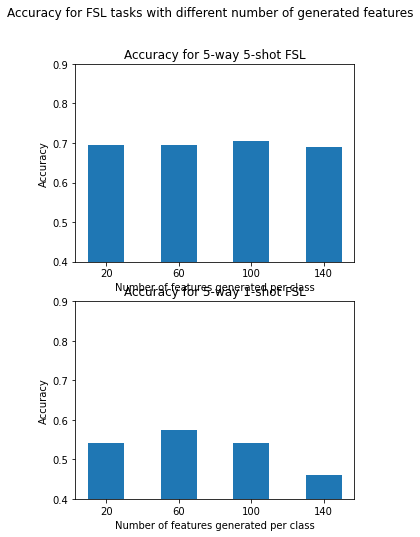

In [306]:
display_result(values)

In [296]:
discriminator.eval()
generator.eval()
N= 5
K= 5
extra_k = 20
batch_size= N*K
start_class = 10
n_classes = 100
dataloaderS, dataloaderQ = getDataLoaders2(train_features_map,test_features_map, K,N,start_class) 
for (feats, labels), (Q_feats, Q_labels) in zip(dataloaderS, dataloaderQ):
  real_feats = torch.tensor(feats).view(batch_size, -1).to(device)
  Q_feats = torch.tensor(Q_feats).view(N, -1).to(device)
  labels = labels.to(device)
  Q_labels = Q_labels.to(device)
  batch_x = []
  batch_y = []
  contexts = np.zeros((n_classes, feat_size))
  for i in range(real_feats.size(0)):
    contexts[labels[i]] += real_feats[i].cpu().numpy()

  contexts = contexts / K
  contexts = Tensor(contexts).float().to(device)
  for j in range(Q_labels.shape[0]):
    label_gen = torch.tensor([Q_labels[j]] * extra_k).to(device)   #.view(extra_k, -1)
    z =  Variable(Tensor(np.random.normal(0, 1, (extra_k, feat_size))).float().to(device))
    s_images = generator(z, label_gen, contexts)
    batch_x.append(s_images.detach())
    batch_y.append(label_gen)
  batch_x = torch.cat(batch_x, dim=0)
  batch_y = torch.cat(batch_y, dim=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [297]:
gen_feats = batch_x.cpu().numpy()
labels = batch_y.cpu().numpy()

In [298]:
def normalize(col):
  maxi = col.max()
  mini = col.min()

  return (col - mini) / (maxi -mini)

In [299]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(gen_feats)

X_0 = normalize(X_embedded[:,0])
X_1 = normalize(X_embedded[:,1])
# X_embedded[:,0].max()

In [300]:
def getColor(val):
  if(val == 10):
    return 'red'
  elif(val == 11):
    return "green"
  elif(val == 12):
    return "black"
  elif (val ==13):
    return "yellow"
  else:
    return "orange"
colors = np.vectorize(getColor)(labels)

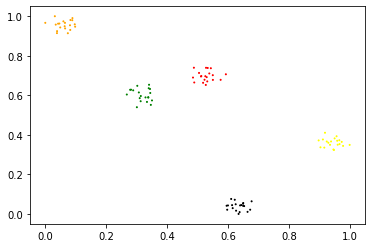

In [301]:

plt.scatter(X_0, X_1, color = colors, s= 1)